# Runtime Analysis / Feasability Exploration

## Imports

In [5]:
import pathlib 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

In [7]:
import gc
gc.collect()

0

## Data Preprocessing

In [8]:
train_dir =  pathlib.Path("./data/train/")
test_dir =  pathlib.Path("./data/test/")

In [9]:
class_names = np.array(sorted([item.name for item in train_dir.glob("*")])) # creating a list of class names from subdirectory 
print(class_names)

['adidas' 'converse' 'nike']


In [10]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=train_dir,
                                                     target_size=(240, 240),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=train_dir,
                                                     target_size=(240, 240),
                                                     subset='validation',
                                                    ),
}

# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

Found 625 images belonging to 3 classes.
Found 67 images belonging to 3 classes.
steps_per_epoch : 19
validation_steps : 2


## Model Training

In [13]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.ResNet50V2(include_top= False,)

# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(240,240,3), name = "input-layer")

#4. Rescaling
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history
history = model_0.fit(train_generator,
                        epochs=20,
                        steps_per_epoch = steps_per_epoch,
                        validation_data = valid_generator,
                        validation_steps = validation_steps)

Shape after passing inputs through base model: (None, 8, 8, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)
Epoch 1/20


2023-07-28 19:33:25.100975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


19/19 [==============================] - ETA: 0s - loss: 1.2442 - accuracy: 0.3659

2023-07-28 19:33:40.310097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


19/19 [==============================] - 17s 580ms/step - loss: 1.2442 - accuracy: 0.3659 - val_loss: 0.9031 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 8s 407ms/step - loss: 0.8715 - accuracy: 0.5953 - val_loss: 0.7139 - val_accuracy: 0.6875
Epoch 3/20
19/19 [==============================] - 9s 482ms/step - loss: 0.7325 - accuracy: 0.7049 - val_loss: 0.6149 - val_accuracy: 0.7344
Epoch 4/20
19/19 [==============================] - 12s 643ms/step - loss: 0.6473 - accuracy: 0.7420 - val_loss: 0.5970 - val_accuracy: 0.7344
Epoch 5/20
19/19 [==============================] - 11s 564ms/step - loss: 0.6065 - accuracy: 0.7487 - val_loss: 0.5744 - val_accuracy: 0.7500
Epoch 6/20
19/19 [==============================] - 10s 513ms/step - loss: 0.5160 - accuracy: 0.8027 - val_loss: 0.5482 - val_accuracy: 0.7812
Epoch 7/20
19/19 [==============================] - 12s 592ms/step - loss: 0.5344 - accuracy: 0.7858 - val_loss: 0.5366 - val_accuracy: 0.7812
Epoch 8/20
1

### Save Model

In [14]:
tf.keras.saving.save_model(history.model, 'model.h5', overwrite=True, save_format=None)

In [15]:
model = tf.keras.saving.load_model('model.h5', compile=True)

## Model Evaluation

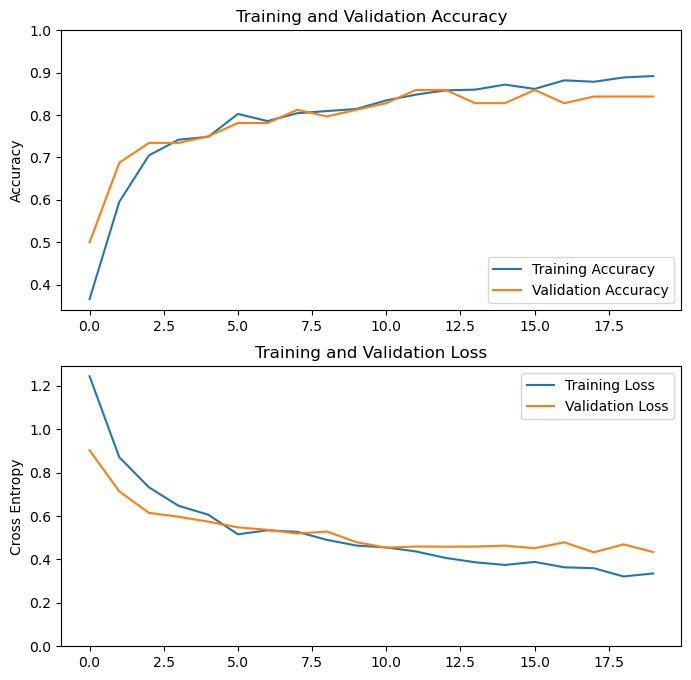

In [16]:
def plot(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    # ________________ Graph 1 -------------------------

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    # ________________ Graph 2 -------------------------

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

plot(history.history)

In [17]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

2023-07-28 19:39:06.844990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 3s 761ms/step - loss: 0.4275 - accuracy: 0.8507
test accuracy :  0.8507462739944458


In [18]:
# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (240, 240)
    img = image.load_img(img_rel_path, target_size=(240, 240))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'adidas', 1: 'converse', 2: 'nike'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

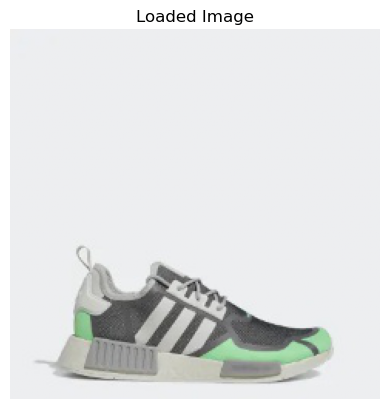

1/1 [==============================] - 2s 2s/step


Maximum Probability:  0.9649469
Classified: adidas 



-------------------Individual Probability--------------------------------

ADIDAS : 96.49 %
CONVERSE : 0.34 %
NIKE : 3.17 %


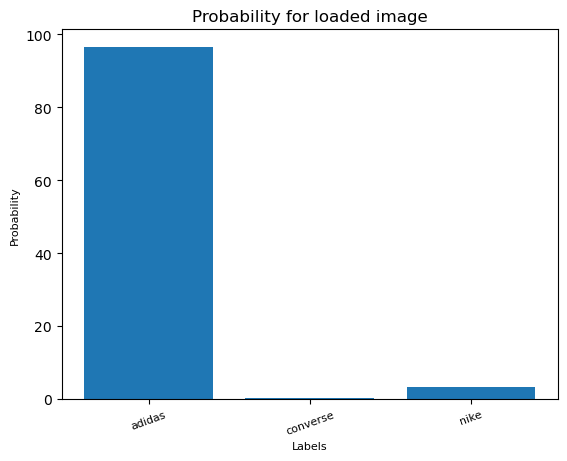

In [19]:
predict("./data/test/adidas/24.jpg")

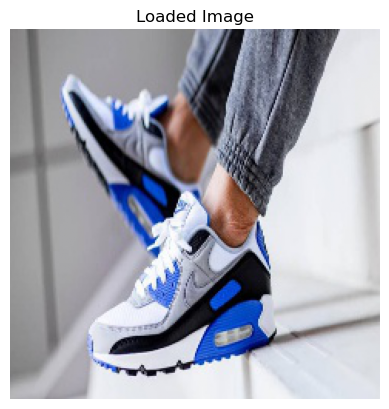

1/1 [==============================] - 0s 27ms/step


Maximum Probability:  0.86633396
Classified: nike 



-------------------Individual Probability--------------------------------

ADIDAS : 9.68 %
CONVERSE : 3.69 %
NIKE : 86.63 %


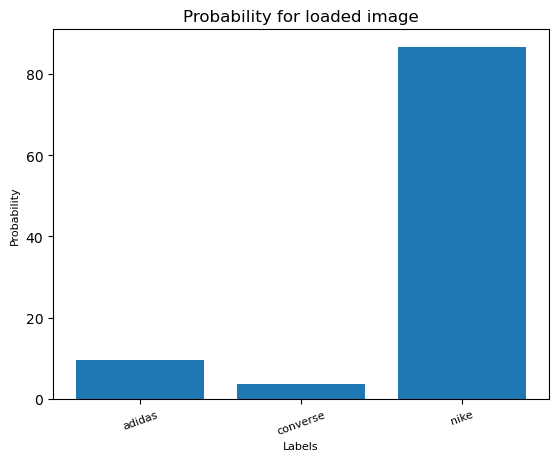

In [20]:
predict("./data/test/nike/24.jpg")

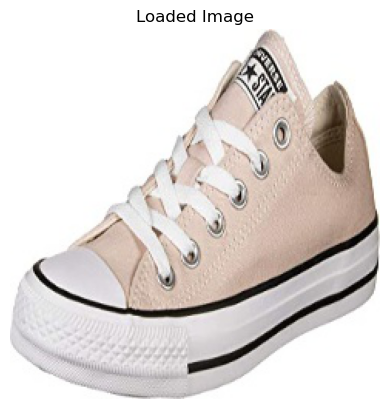

1/1 [==============================] - 0s 24ms/step


Maximum Probability:  0.8827616
Classified: converse 



-------------------Individual Probability--------------------------------

ADIDAS : 4.34 %
CONVERSE : 88.28 %
NIKE : 7.39 %


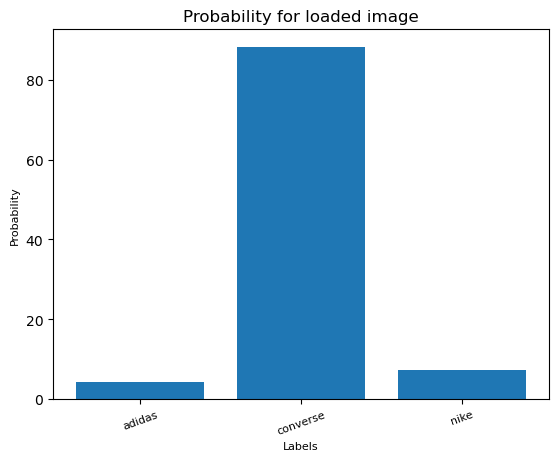

In [21]:
predict("./data/test/converse/24.jpg")

## Keras Tuner

https://keras.io/guides/keras_tuner/

In [26]:
from keras_tuner.applications import HyperResNet
from keras_tuner import RandomSearch

hypermodel = HyperResNet(input_shape=(240, 240, 3), classes=3)

tuner = RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=2,
    overwrite=True,
    directory="my_dir",
    project_name="built_in_hypermodel",
)

tuner.search(
    train_generator, epochs=1, validation_data=valid_generator
)

Trial 2 Complete [00h 00m 49s]

Best val_accuracy So Far: None
Total elapsed time: 00h 01m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()